#### Kaggle competition

- Label satellite image chips with atmospheric conditions and various classes of land cover/land use.
- Each chip will have one atmospheric label and zero or more common and rare labels
- 17 Unique labels, 4 weather labels and 13 land use labels

#### What the data looks like ?
Please check EDA.ipynb for EDA part <br>
<img style="float:left; width:600px; display: block;margin-right: 350px" src="img/eg1.jpg" />

#### Challenge
Unlike dog and cat image recognition, the image set are very similar in colors
Labels are highly imbalanced with a few labelling errors

#### Environment
```terminal
source activate tensorflow_p36
```

#### Kaggle Evaluation - F2 SCORE
F2 is used to evaluate how good the model is and has a formula given below. It puts more weight on precision

$F_{2} = (1+β^{2})\frac{pr}{β^{2}p+r}$


,where *p* is precision, *r* is recall and β=2 
<br>



shortcuts (this is a quick start for me for me, ignore if you are reading it )
```terminal
cd ~/Desktop/metis_proj
source activate tensorflow_p36
jupyter notebook
```

In [12]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,fbeta_score,coverage_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import math, glob, os
import operator, pickle
import cv2

#### Read in labels and convert text labels to count vectors
- df_labels shape = (40479, 17)
- total train size 40479 with 17 unique label tags

In [2]:
"""GLOBAL VARIABLE"""
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
# kaggle_path = '/Users/mumuxi/.kaggle/competitions/planet-understanding-the-amazon-from-space/'

def get_multitags(plot=False):
    texts = pd.read_csv(kaggle_path+'train_v2.csv').tags.tolist()
    tokenizer = Tokenizer(filters = '"(),./:~')
    tokenizer.fit_on_texts(texts)
    M  = tokenizer.texts_to_matrix(texts, mode='count')
    df = pd.DataFrame(data=M,columns=['0']+list(tokenizer.word_index.keys()))
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[1:-1]]
    df = df.where(df <= 1, 1) #some photos cultivation appreared twice
    if plot:
        corr = df.corr()
        fig=plt.figure(figsize=(10, 8))
        sns.heatmap(corr)
    return df

df_label = get_multitags()

In [3]:
df_label.head(3)

,conventional_mine,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1. Predict weather labels (Multiclass classification)
- Weather labels are exclusive
- Predict clear,haze,partly_cloudy,cloudy tags
- Define weather_tags = \['clear','haze','partly_cloudy','cloudy'\]


All train images contains 1 weather label, except train_img2448.jpg has none

#### 1.1 old opencv statistical approach
- multi-class logistic 
- random forest
- gradient boosted random forest

#### 1.2 modern neutral network approach
- CNN
- Pre-trained VGG16

In [4]:
def categorical_to_array(y,no_features):
    y.columns=range(no_features)
    y = pd.get_dummies(y).idxmax(1)
    return y.values

def plot_confusion_matrix(y_test,y_pred,x_labels):
    M = confusion_matrix(y_test,y_pred)
    M = M/M.sum(axis=1)[:,None]
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(M, annot=True,fmt='.0%',cmap="YlGnBu")
    ax.set_xticklabels(x_labels,rotation=30)
    ax.set_yticklabels(x_labels,rotation=30)
    plt.show()
    
class Statistical_Approach():
    """ Predict weather labels 
        Input: image contrast, haziness and atomospheric light {max intensity at the darkest channel} """
    def __init__(self):
        self.maxdepth = 3
        self.random_num = 5678
        self.tags = ['clear','haze','partly_cloudy','cloudy']
        self.no_features = len(self.tags)
        
   
    def __load_data(self):
        df_w = pd.DataFrame(data = pickle.load(open("haze_train.pkl", "rb")),
                            columns = ['id','w','A'])
        y = categorical_to_array(df_label[self.tags].copy(),self.no_features)
        return train_test_split(df_w[['w','A']],y,
                                 stratify=y,
                                 test_size=0.3,
                                 random_state=self.random_num)
    
    def multi_class_logistic(self,x_train,x_test,y_train,y_test):
        print ('multi class logistic')    
        lgr = LogisticRegression(multi_class="multinomial",
                                 solver='newton-cg')
        lgr.fit(x_train, y_train)
        y_pred = lgr.predict(x_test)
        plot_confusion_matrix(y_test,y_pred,x_labels=self.tags)
    
    def random_forest(self,x_train,x_test,y_train,y_test):
        print ('basic random forest')     
        rf = RandomForestClassifier(max_depth=self.maxdepth)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_test)
        plot_confusion_matrix(y_test,y_pred)
    
    def gbm_tree(self,x_train,x_test,y_train,y_test):
        x_train, x_val, y_train, y_val = train_test_split(
                                                          x_train, y_train, 
                                                          stratify=y_train,
                                                          test_size=0.3, 
                                                          random_state=self.random_num)
        gbm = xgb.XGBRegressor( 
                               n_estimators=3000, #arbitrary large number
                               max_depth=self.maxdepth,
                               objective="multi:softprob",
                               learning_rate=.1, 
                               subsample=1,
                               min_child_weight=1,
                               colsample_bytree=.5,  
                               num_class=self.no_features
                              )

        eval_set=[(x_train,y_train),(x_val,y_val)] #tracking train/validation error as we go
        gbm.fit( 
                x_train, y_train, 
                eval_set=eval_set,
                eval_metric='mlogloss',
                early_stopping_rounds=50,
                verbose=True #gives output log as below
        )
        y_pred = gbm.predict(x_test, ntree_limit=gbm.best_ntree_limit).argmax(axis=1)
        plot_confusion_matrix(y_test,y_pred)

        
    def run_models(self):
        x_train,x_test,y_train,y_test = self.__load_data__()
        self.multi_class_logistic(x_train,x_test,y_train,y_test)
        self.random_forest(x_train,x_test,y_train,y_test)
        self.gbm_tree(x_train,x_test,y_train,y_test)


NameError: name 'weather_tags' is not defined

multi class logistic


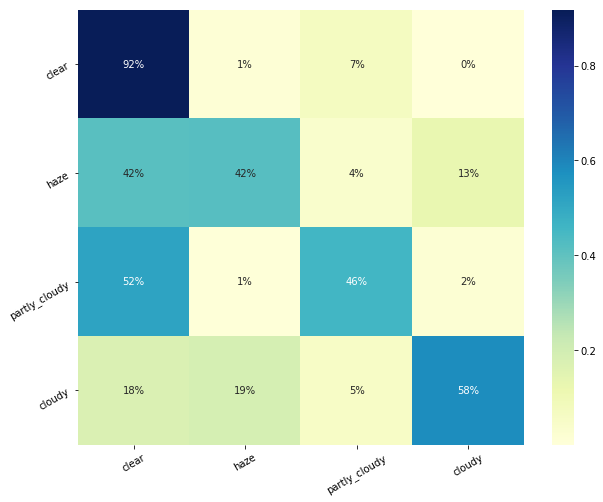

basic random forest


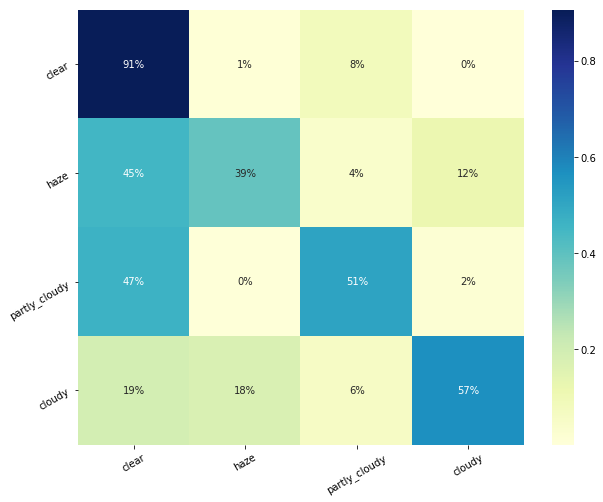

[0]	validation_0-mlogloss:1.29301	validation_1-mlogloss:1.29337
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.21561	validation_1-mlogloss:1.21627
[2]	validation_0-mlogloss:1.14683	validation_1-mlogloss:1.14715
[3]	validation_0-mlogloss:1.09102	validation_1-mlogloss:1.09105
[4]	validation_0-mlogloss:1.03858	validation_1-mlogloss:1.03857
[5]	validation_0-mlogloss:0.997669	validation_1-mlogloss:0.997934
[6]	validation_0-mlogloss:0.960643	validation_1-mlogloss:0.960871
[7]	validation_0-mlogloss:0.916801	validation_1-mlogloss:0.916401
[8]	validation_0-mlogloss:0.884701	validation_1-mlogloss:0.883923
[9]	validation_0-mlogloss:0.859046	validation_1-mlogloss:0.858236
[10]	validation_0-mlogloss:0.83638	validation_1-mlogloss:0.835522
[11]	validation_0-mlogloss:0.810215	validation_1-mlogloss:0.809202
[12]	validation_0-mlogloss:0.786686	validation_1-m

[121]	validation_0-mlogloss:0.475713	validation_1-mlogloss:0.477097
[122]	validation_0-mlogloss:0.475504	validation_1-mlogloss:0.476971
[123]	validation_0-mlogloss:0.475287	validation_1-mlogloss:0.476898
[124]	validation_0-mlogloss:0.475174	validation_1-mlogloss:0.476811
[125]	validation_0-mlogloss:0.47498	validation_1-mlogloss:0.476639
[126]	validation_0-mlogloss:0.47478	validation_1-mlogloss:0.476484
[127]	validation_0-mlogloss:0.474597	validation_1-mlogloss:0.476418
[128]	validation_0-mlogloss:0.474377	validation_1-mlogloss:0.476293
[129]	validation_0-mlogloss:0.474256	validation_1-mlogloss:0.47621
[130]	validation_0-mlogloss:0.474117	validation_1-mlogloss:0.476124
[131]	validation_0-mlogloss:0.473965	validation_1-mlogloss:0.476021
[132]	validation_0-mlogloss:0.47374	validation_1-mlogloss:0.475928
[133]	validation_0-mlogloss:0.473586	validation_1-mlogloss:0.475842
[134]	validation_0-mlogloss:0.473435	validation_1-mlogloss:0.475766
[135]	validation_0-mlogloss:0.473242	validation_1-ml

[242]	validation_0-mlogloss:0.463921	validation_1-mlogloss:0.473803
[243]	validation_0-mlogloss:0.463846	validation_1-mlogloss:0.473826
[244]	validation_0-mlogloss:0.463746	validation_1-mlogloss:0.473817
[245]	validation_0-mlogloss:0.463712	validation_1-mlogloss:0.473804
[246]	validation_0-mlogloss:0.463654	validation_1-mlogloss:0.473846
[247]	validation_0-mlogloss:0.463584	validation_1-mlogloss:0.473841
[248]	validation_0-mlogloss:0.463538	validation_1-mlogloss:0.473855
[249]	validation_0-mlogloss:0.463473	validation_1-mlogloss:0.473879
[250]	validation_0-mlogloss:0.46343	validation_1-mlogloss:0.473879
[251]	validation_0-mlogloss:0.46335	validation_1-mlogloss:0.473847
[252]	validation_0-mlogloss:0.463293	validation_1-mlogloss:0.473841
[253]	validation_0-mlogloss:0.463229	validation_1-mlogloss:0.473841
[254]	validation_0-mlogloss:0.463172	validation_1-mlogloss:0.473829
[255]	validation_0-mlogloss:0.463117	validation_1-mlogloss:0.473871
[256]	validation_0-mlogloss:0.463049	validation_1-

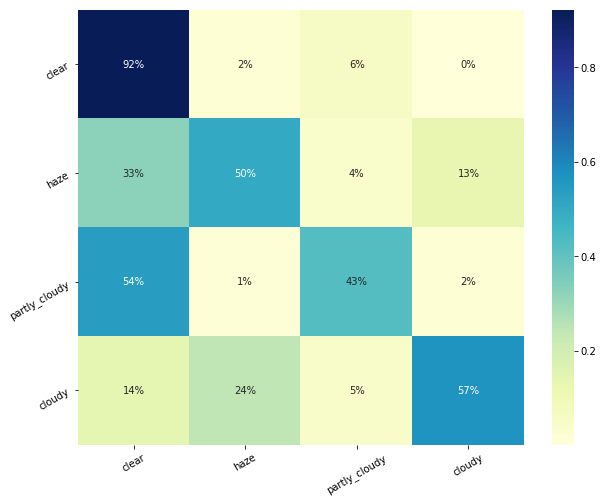

In [12]:
ss_predictor = Statistical_Approach()
ss_predictor.run_models()

####  1.2 Neural Network model

Initialise model as a sequential network. There are two basic ways of initialising a neural network, either by a sequence of layers or as a graph

####  Load data
- opencv convert image to numpy array (256x256x3) 256 pixels 3 RBG channels
- train/test split

####  Model Work Flow
1. **Conv2D** 
    - Images => 2 D arrays
    - Videos => Convolution 3-D 
    
    
2. **MaxPooling2D**:<br> The primary aim of a pooling operation is to reduce the size of the images. Different types of pooling operations like Min Pooling, Mean Pooling, etc. Here in MaxPooling we need the maximum value pixel from the respective region of interest.


3. **Flatten**:<br> Flattening is the process of converting all the resultant 2 dimensional arrays into a continuous vector.


4. **Dense** 
    - units: no nodes in the hidden layer
5. **Compile**
    - Optimizer:  stochastic gradient descent algorithm
    - Loss: loss function
    - Metrics: performance metric

In [4]:
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization,InputLayer
from keras.initializers import glorot_normal, RandomNormal, Zeros
from keras.optimizers import SGD
import keras

In [66]:
""" Define matrice functions """
def precision(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true,y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def F2_score(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return (1+4)*precision*recall/(4*precision+recall)
    
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)    
#       if u wanna use Keras img_generator instead of __data_transformation(). however img_gen was much slower 
#         model.fit_generator(datagen.flow(X_train, y_train, batch_size=self.batch_size),
#                             steps_per_epoch=len(X_train)/self.batch_size, epochs=self.epochs)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
class MyCNN(keras.utils.Sequence):
    def __init__(self,label_class,haze_free,optimizer, loss, class_weight,epochs,batch_size):
        self.labels, self.no_features = self.choose_labels(label_class)
        self.haze_free = haze_free
        self.optimizer = optimizer
        self.class_weight = class_weight
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size

    def choose_labels(self,label_class=0):
        """  label class 0 : weather labels ; 1 : land_cover labels   """
        weather  = ['clear','haze','partly_cloudy','cloudy']
        land_use = ['primary', 'agriculture', 'road', 'water','cultivation', 'habitation','bare_ground', 
                    'conventional_mine', 'selective_logging', 'artisinal_mine', 'blooming','slash_burn', 'blow_down']
        
        labels = weather if label_class==0 else land_use
        no_features = 4 if label_class==0 else 13
        return labels, no_features
    
    def __data_transformation(self,X_):
        _id = range(len(X_))
        for flip_id in random.sample(_id, len(X_)//10):
            X_[flip_id] = X_[flip_id][::-1, :, :]    
        for rotate_id in random.sample(_id, len(X_)//10):
            X_[flip_id] = np.rot90(X_[flip_id], k=random.randint(0, 3))
        return X_
  
    def __data_generation(self):
        'Generates data' 
        path =  '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
        path += 'train_haze_free/' if self.haze_free else 'train-jpg/'
        read = lambda i: cv2.imread(path+f'train_{i}.jpg')
        y_train, y_test = train_test_split(df_label[self.labels], test_size=0.3,random_state=1100)
        X_train = self.__data_transformation(np.array(list(map(read,y_train.index.tolist()))))
        X_test = self.__data_transformation(np.array(list(map(read,y_test.index.tolist()))))
        return X_train,y_train,X_test,y_test
    
    def __build_layers(self):
        model = Sequential()

        model.add(InputLayer(input_shape = (256, 256, 3)))
        model.add(BatchNormalization())

        model.add(Conv2D(32, (3, 3),activation = 'relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 2)))

        model.add(Conv2D(32, (3, 3),activation = 'relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 2)))

        model.add(Conv2D(32, (3, 3),activation = 'relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3, 2)))

        model.add(Flatten())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.2))
        model.add(Dense(self.no_features))
        model.add(Activation('sigmoid'))
    #     model.summary()
        return model
    
    def __build_model(self):
        model = self.__build_layers()
        model.compile(optimizer = self.optimizer, 
                      loss = self.loss, 
                      metrics = ['accuracy',F2_score])
        return model
    
    def train_model(self):
        model = self.__build_model()
        X_train,y_train,X_test,y_test = self.__data_generation()
        print ('data done')
        cb_1 = keras.callbacks.EarlyStopping(monitor='F2_score', patience=PATIENCE, verbose=0)
        cb_2 = keras.callbacks.ModelCheckpoint(filepath="cnn_weight.hdf5", monitor='F2_score', 
                                               verbose=0, save_best_only=True, mode='auto', period=1)
        cb_loss = LossHistory()
        model.fit(X_train, y_train, batch_size=self.batch_size, 
                  epochs=self.epochs,
                  callbacks=[cb_1,cb_2,cb_loss],
                  class_weight = self.class_weight)
        return (X_train,y_train,X_test,y_test,model,cb_loss.losses)
    
    
    def train_model_with_data(self,X_train,y_train):
        model = self.__build_model()
        cb_1 = keras.callbacks.EarlyStopping(monitor='F2_score', patience=PATIENCE, verbose=0)
        cb_2 = keras.callbacks.ModelCheckpoint(filepath="cnn_weight.hdf5", monitor='F2_score', verbose=0, save_best_only=True, mode='auto', period=1)
        cb_loss = LossHistory()
                                
        model.fit(X_train, y_train, batch_size=self.batch_size, 
                  epochs=self.epochs,
                  callbacks=[cb_1,cb_2,cb_loss],
                  class_weight = self.class_weight
                 )
        return model, cb_loss.losses
    
PATIENCE = 50    
params = {'label_class': 1,
          'haze_free': False,
          'optimizer':'adam',
          'loss': 'categorical_crossentropy',
          'class_weight': {0: 1.,
                           1: 2,
                           2: 2.,
                           3: 2.,
                           4: 2,
                           5: 2.,
                           6: 2,
                           7: 100,
                           8: 100,
                           9: 100,
                           10: 100,
                           11: 100,
                           12: 100},
          'epochs': 6,
          'batch_size': 32
         }

c = MyCNN(**params)
X_train,y_train,X_test,y_test, cnn, loss = c.train_model()
# cnn, loss = c.train_model_with_data(X_train,y_train)

data done
Epoch 1/6
28335/28335 [==============================] - 118s 4ms/step - loss: 3.2499 - acc: 0.6685 - F2_score: 0.6281
Epoch 2/6
28335/28335 [==============================] - 116s 4ms/step - loss: 2.7644 - acc: 0.9380 - F2_score: 0.6938
Epoch 3/6
28335/28335 [==============================] - 116s 4ms/step - loss: 2.6699 - acc: 0.9619 - F2_score: 0.7186
Epoch 4/6
28335/28335 [==============================] - 116s 4ms/step - loss: 2.6323 - acc: 0.9707 - F2_score: 0.7262
Epoch 5/6
28335/28335 [==============================] - 116s 4ms/step - loss: 2.5922 - acc: 0.9761 - F2_score: 0.7382
Epoch 6/6
28335/28335 [==============================] - 116s 4ms/step - loss: 2.5593 - acc: 0.9767 - F2_score: 0.7392
Data done


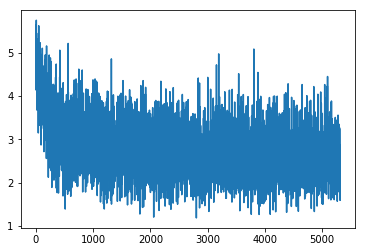

In [40]:
#SOPH: Increase Conv Units. 
# Consider adding more layers (so that your final conv layer is close to 2x2)
# add dropout. even if your model is overfit, a small dropout helps (~5%)
# (maybe) try replacing Flatten() with GlobalAvgPool()
# X_train.shape,X_test.shape
plt.plot(loss)

In [10]:
cnn2 = c.train_model_with_data(X_train,y_train) #with early stopping

Epoch 1/6
28335/28335 [==============================] - 125s 4ms/step - loss: 3.2483 - acc: 0.6661 - F2_score: 0.6013
Epoch 2/6
28335/28335 [==============================] - 123s 4ms/step - loss: 2.7429 - acc: 0.9437 - F2_score: 0.6887
Epoch 3/6
28335/28335 [==============================] - 123s 4ms/step - loss: 2.6460 - acc: 0.9714 - F2_score: 0.7231
Epoch 4/6
28335/28335 [==============================] - 123s 4ms/step - loss: 2.5890 - acc: 0.9748 - F2_score: 0.7366
Epoch 5/6
28335/28335 [==============================] - 123s 4ms/step - loss: 2.5516 - acc: 0.9736 - F2_score: 0.7448
Epoch 6/6
28335/28335 [==============================] - 122s 4ms/step - loss: 2.5131 - acc: 0.9752 - F2_score: 0.7562


In [68]:
y_pred_train = cnn.predict(X_train)
y_pred_test  = cnn.predict(X_test)

In [69]:
def tuning_threshold(y_pred,y_true,show=False):
    f2 = []
    precision = []
    recall = []
    t = np.linspace(0.01,1,100)
    for threshold in t :
        y = (y_pred>threshold)*1
        f = fbeta_score(y_true, y, average='binary', beta=2)
        f2.append(f)
        p, r, _,__ = precision_recall_fscore_support(y_true,y,average = 'binary')
        precision.append(p)
        recall.append(r)
    threshold = t[len(f2)-f2[::-1].index(max(f2))-1]
    if show:
        print (n,threshold)
        fig, ax1 = plt.subplots()    
        ax1.plot(t, precision, 'b-')
        ax1.plot(t, f2, 'b*')

        ax1.set_xlabel('threshold')
        # Make the y-axis label, ticks and tick labels match the line color.
        ax1.set_ylabel('precision', color='b')
        ax1.tick_params('y', colors='b')
        ax1.set_ylim([0,1])

        ax2 = ax1.twinx()
        ax2.plot(t, recall, 'r.')
        ax2.set_ylabel('recall', color='r')
        ax2.tick_params('y', colors='r')
        ax2.set_ylim([0,1])

        fig.tight_layout()
        ax1.grid(True, which='both')
        plt.show()
    return round(threshold ,3)

threshold = {}
for n in range(13):
    threshold[y_test.columns[n]] = tuning_threshold(y_pred_train[:,n],y_train.iloc[:,n],show=False)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted sample

In [67]:
threshold.keys()              

dict_keys(['primary', 'agriculture', 'road', 'water', 'cultivation', 'habitation', 'bare_ground', 'conventional_mine', 'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down'])

In [73]:
def multilable_confusion_matrix(y_pred,y_true):
    y_pred = ((y_pred-np.array(list(threshold.values())))>0)*1
    for n in range(13):
        print (round(fbeta_score(y_true.iloc[:,n], y_pred[:,n], average='binary', beta=2),3))
        M = confusion_matrix(y_true.iloc[:,n], y_pred[:,n])
#         sns.heatmap(M, annot=True,fmt='d',cmap="YlGnBu")
#         plt.show()
        



In [74]:
multilable_confusion_matrix(y_pred_train,y_train)


0.984
0.828
0.758
0.657
0.598
0.642
0.355
0.346
0.386
0.514
0.169
0.274
0.134


In [75]:
multilable_confusion_matrix(y_pred_test,y_test)

0.984
0.824
0.753
0.663
0.57
0.639
0.33
0.254
0.114
0.353
0.16
0.072
0.136


#### 1.3 Try vgg16 and rasnet

In [ ]:
from keras.applications.vgg16 import VGG16
#Get back the convolutional part of a VGG network trained on ImageNet
def vgg_16():
    # VGG16
    input_tensor = Input(shape=(256,256,3))
    vgg16_model = VGG16(weights = "imagenet", include_top=False)
    vgg16_model_output = vgg16_model(input_tensor)
    vgg16_model = VGG16(include_top=False, weights=None, input_tensor=input_tensor)

    x = Flatten(name='flatten')(vgg16_model(input_tensor))
    x = Dense(256, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(no_features, activation='softmax')(x)
    model = Model(input=input_tensor, output=x)  # Using the Functional API

    for layer in model.layers[:2]:      
        layer.trainable = False

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=[F2_score])
    cb_a=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
    model.fit(X_train, y_train,
              batch_size=32, epochs=1, verbose=1,
              validation_data=(X_test, y_test),
              callbacks=[cb_a])
    y_pred = model.predict(X_test)
    plot_confusion_matrix(categorical_to_array(y_test,no_features),y_pred.argmax(axis=1))
    return 

# vgg16_y = vgg_16()

In [ ]:
class vgg(myCNN):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, 224, 224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(no_features, activation='sigmoid'))


#### 1.3 Implementation
Build different models and test
F2 | prec  |  recall
_________________________

0.70 | 0.47 | 0.75 | model 2 Test F2: 0.754 - multi layers

0.00 | 0.00 | 0.00 | model 3 - haze free

-  Divide labels to 2 categories.
    - weather labels
    - non-weather labels
-  Run model on haze free images



In [3]:
"""Single image dehazing."""
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray,img_width=256):
    """return Atomospheric light A 
       find brightest pixels in the dark channel and find max intensity
    """
    toplist = [Channel_value()] * 2
    dark_channel = find_dark_channel(img)
    coords = np.argwhere(img[:,:,dark_channel] == np.max(img[:,:,dark_channel]) )
    I = [gray[c[0],c[1]] for c in coords]
    return max(I)

def find_dark_channel(img): #get darkest RBG channel
    return np.unravel_index(np.argmin(img), img.shape)[2]

def clamp(minimum, x, maximum):
    return max(minimum, min(x, maximum))

def dehaze_function(img, light_intensity, windowSize, t0, w,img_width=256):
    outimg = np.zeros(img.shape, img.dtype)
    # sliding windowns
    # try tf.train.batch
    for y in range(img_width):
        for x in range(img_width):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), img_width)
            y_high = min(y+(windowSize//2), img_width)
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))
    return outimg


def dehaze_image(path,w = 0.95, t0 = 0.55):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    light_intensity = find_intensity_of_atmospheric_light(img, gray)
    outimg = dehaze_function(img, light_intensity, 20, t0, w)
    return outimg

#  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def display_photo_no(image_id, folder='train-jpg/'):
    img = cv2.imread(kaggle_path+folder+f'train_{image_id}.jpg')
    plt.imshow(img)
    return


In [22]:
miu, v, sigma = 5.1,2.9,.2461
def calculate_haziness(img_id):
    path = kaggle_path+f'train-jpg/train_{img_id}.jpg'
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #image to gray scale
    A = find_intensity_of_atmospheric_light(img, gray)
    D = img.min(2).sum()/(img.shape[0]*img.shape[1])
    B = img.max(2).sum()/(img.shape[0]*img.shape[1])
    C = B - D
    w = math.e**(-0.5*(miu*(A-D)/A+v*C/A))
    return (img_id,w,A)

def compare_photos(image_id):
    path = kaggle_path+f'train-jpg/train_{image_id}.jpg'
    fig=plt.figure(figsize=(5, 8))
    ax1 = fig.add_subplot(211)
    dehazed_img = dehaze_image(path)
    plt.imshow(dehazed_img)
    fig.add_subplot(212,sharex=ax1)
    display_photo_no(image_id)
    plt.show()
# display_photo_no(33)
compare_photos(33)

In [ ]:
# from multiprocessing import Pool
# import pickle

# res = []
# d = range(0,40479,1)
# chunks = [d[x:x+5000] for x in range(0, len(d), 5000)]
# pool = Pool(6)
# for rang in chunks:
#     print (rang)
#     res+=pool.map(calculate_haziness,rang)
# pool.close()
# pool.join()
# with open('haze_train.pkl', 'wb') as f:
#     pickle.dump(res, f)

In [6]:
import glob
kaggle_path = '/home/ubuntu/.kaggle/competitions/planet-understanding-the-amazon-from-space/'
x = glob.glob(kaggle_path+'test_haze_free/test_*.jpg')
x = sorted([int(i.split('_')[-1].rstrip('.jpg')) for i in x])
x[5800]

5800

In [ ]:
display_photo_no(25,folder='train_haze_free/')

In [14]:
df_label.head()

,conventional_mine,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,blow_down
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=123)
results = cross_val_score(estimator, X, y cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

SyntaxError: invalid syntax (<ipython-input-4-37a23d63e786>, line 5)

#### Appendix
version 1 - single layer
```python
def build_layers():
    """32 filters of size 12x12
        input image size 256 x 256, 3 for RGB
    """
    no_features = 17
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(12,12), activation = 'relu',input_shape = (256, 256, 3)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = no_features, activation = 'sigmoid'))
    return model
```

```terminal
ls -1 | wc -l    #find number of files in the directary
ls -Art | tail -n 1  # lastest file added in to the folder

```


In [30]:
# # Defining the generator:

# # https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

# class SubDataGenerator(keras.utils.Sequence):
#     def __init__(self, list_IDs, batch_size=3, dim=(256,256), n_channels=4,
#                  n_classes=3, shuffle=True):
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()
#         print (self.indexes)

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]
#         # Generate data
#         X, y1, y2 = self.__data_generation(list_IDs_temp)

#         return X, [y1, y2]

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' 
#         # Initialization
#         X  = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y1 = np.empty((self.batch_size,4))
#         y2  = np.empty((self.batch_size,13))
#         for i, ID in enumerate(list_IDs_temp):
#             print (ID)
#             X[i,] = cv2.imread(kaggle_path+f'train_haze_free/train_{ID}.jpg')
#             y1[i,] = self.labels[weather_tags].iloc[[ID]].values
#             y2[i,] = self.labels[land_cover_tags].iloc[[ID]].values
#         print (y1.shape,X.shape)
#         return X, y1, y2


# # Fit_generator for training:
# read = lambda i: cv2.imread(kaggle_path+f'train_haze_free/train_{i}.jpg')
                            
# params = {'dim': (256,256),
#           'batch_size': 2,
#           'n_classes': 13,
#           'n_channels': 3,
#           'shuffle': True}

# partition = {'train':range(100)}
# labels = df_label

# # # Generators
# training_generator = SubDataGenerator(partition['train'], **params)

# # validation_generator = SubDataGenerator(subpartition['test'], **params)

# # cb_1=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
# # cb_2=keras.callbacks.ModelCheckpoint(filepath="3pred_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# model = build_model()
# # model.fit(X_train, y_train, epochs=20, batch_size=50)
    
# results = model.fit_generator(generator=training_generator,
#                    epochs=1, 
#                    nb_worker=4)